In [1]:
import pyBigWig
import pandas as pd
import numpy as np
import deepdish as dd
import os
import pyfaidx
import random
import pickle as pkl
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import json
import dinuc_shuffle_main
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"
%matplotlib inline

In [2]:
regions = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/negatives_data/negatives_with_summit.bed"
genome = "/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"
model_h5 ="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
#model_h5 = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"

In [3]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)


def get_footprint_for_motif(seqs, motif, model, inputlen, batch_size):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    w_mot_seqs = seqs.copy()
    w_mot_seqs[:, midpoint-len(motif)//2:midpoint-len(motif)//2+len(motif)] =dinuc_shuffle_main.dna_to_one_hot([motif])

    # midpoint of motif is the midpoint of sequence
    pred_output=model.predict(w_mot_seqs, batch_size=batch_size, verbose=True)
    footprint_for_motif_fwd = softmax(pred_output[0])*(np.exp(pred_output[1])-1)

    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    pred_output_rev=model.predict(w_mot_seqs_revc, batch_size=batch_size, verbose=True)
    footprint_for_motif_rev = softmax(pred_output_rev[0])*(np.exp(pred_output_rev[1])-1)

    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = np.exp(pred_output_rev[1]) - 1 + np.exp(pred_output[1]) - 1
    footprint_for_motif_tot = footprint_for_motif_fwd+footprint_for_motif_rev[:,::-1]
    footprint_for_motif =  footprint_for_motif_tot / footprint_for_motif_tot.sum(axis=1)[:, np.newaxis]

    return footprint_for_motif_tot.mean(0), counts_for_motif.mean(0)

def get_footprint_for_two_motifs(seqs, motifs, model, inputlen, batch_size, spacing):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    spacing_per_motif = spacing // 2
    
    w_mot_seqs = seqs.copy()
    
    motif = motifs[0]
    start = midpoint-spacing_per_motif-len(motif)
    w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    
    spacing_per_motif = spacing - spacing_per_motif
    motif = motifs[1]
    start = midpoint+spacing_per_motif
    w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
     

    # midpoint of motif is the midpoint of sequence
    pred_output=model.predict(w_mot_seqs, batch_size=batch_size, verbose=True)
    footprint_for_motif_fwd = softmax(pred_output[0])*(np.exp(pred_output[1])-1)

    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    pred_output_rev=model.predict(w_mot_seqs_revc, batch_size=batch_size, verbose=True)
    footprint_for_motif_rev = softmax(pred_output_rev[0])*(np.exp(pred_output_rev[1])-1)

    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = np.exp(pred_output_rev[1]) - 1 + np.exp(pred_output[1]) - 1
    footprint_for_motif_tot = footprint_for_motif_fwd+footprint_for_motif_rev[:,::-1]
    footprint_for_motif =  footprint_for_motif_tot / footprint_for_motif_tot.sum(axis=1)[:, np.newaxis]

    return footprint_for_motif_tot.mean(0), counts_for_motif.mean(0)

In [4]:
def get_seq(peaks_df, genome, width, shuffle=False):
    """
    fetches sequence from a given genome.
    """
    vals = []

    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
                vals.append(sequence)

    return dinuc_shuffle_main.dna_to_one_hot(vals)

In [5]:
model=load_model(model_h5)

In [6]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
inputlen = 2114
regions_df = pd.read_csv(regions, sep='\t', names=NARROWPEAK_SCHEMA)
chroms_to_keep = ["chr1", "chr3", "chr6"]
regions_subsample = regions_df[(regions_df["chr"].isin(chroms_to_keep))].sample(1000, random_state=0)
#regions_subsample = regions_df[(regions_df["chr"].isin(chroms_to_keep))]
print(regions_subsample.shape)

genome_fasta = pyfaidx.Fasta(genome)
regions_seqs = get_seq(regions_subsample, genome_fasta, inputlen)

(1000, 10)


Monomer

In [7]:
motif =  ""
batch_size=128
full_footprint_1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)

8/8 [==============================] - 7s 1s/step


8/8 [==============================] - 7s 1s/step


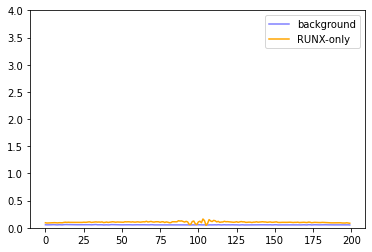

In [8]:
motif = "GCTAACCACAGGC"
batch_size=128
runx_footprint = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(runx_footprint[0][400:600], label="RUNX-only", c = "orange")
plt.ylim((0,4))
plt.legend()
plt.show()

8/8 [==============================] - 7s 1s/step


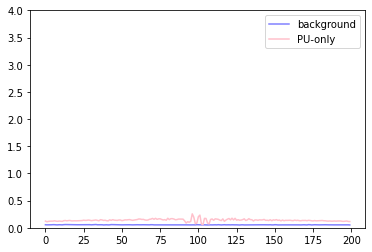

In [9]:
motif = "CGATATGCAAATCAGC"
batch_size=128
puu_footprint = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(puu_footprint[0][400:600], label="PU-only", c = "pink")
plt.ylim((0,4))
plt.legend()
plt.show()

8/8 [==============================] - 7s 1s/step


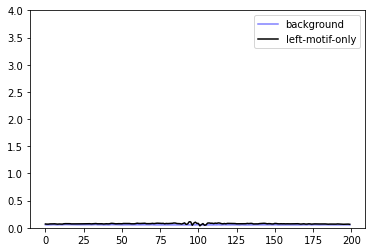

In [10]:
motif =  "TAGTCATCCGGG"
batch_size=128
left_footprint = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(left_footprint[0][400:600], label="left-motif-only", c = "black")
plt.ylim((0,4))
plt.legend()
plt.show()

Dimer

8/8 [==============================] - 7s 1s/step


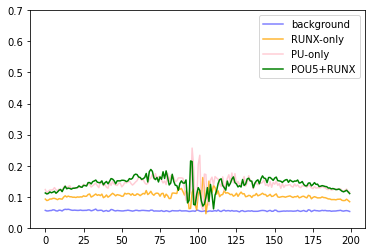

In [11]:
motif = "AAATGCAAATCAAAACCACAACG"
batch_size=128
puu_runx_footprint = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)

plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(runx_footprint[0][400:600], label="RUNX-only", c = "orange", alpha=0.8)
plt.plot(puu_footprint[0][400:600], label="PU-only", c = "pink", alpha=0.8)
plt.plot(puu_runx_footprint[0][400:600], label="POU5+RUNX", c = "green")

plt.ylim((0,0.7))
plt.legend()
plt.show()

In [12]:
motifs =  ["TAGTCATCCGGG", "AACCACAACG"]
batch_size=128
left_runx_footprint = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=13)



8/8 [==============================] - 8s 1s/step


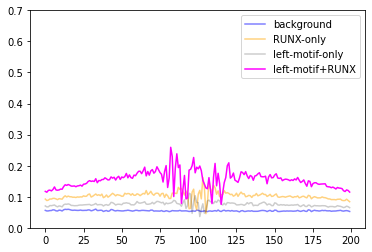

In [13]:
plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(runx_footprint[0][400:600], label="RUNX-only", c = "orange", alpha=0.5)
plt.plot(left_footprint[0][400:600], label="left-motif-only", c = "black", alpha=0.2)
plt.plot(left_runx_footprint[0][400:600], label="left-motif+RUNX", c = "magenta")

plt.ylim((0,0.7))
plt.legend()
plt.show()

8/8 [==============================] - 8s 1s/step


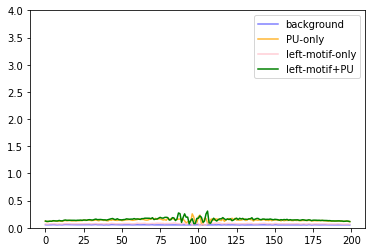

In [14]:
motifs =  ["TAGTCATCCGGG", "ATGCAAATCA"]
batch_size=128
left_puu_footprint = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=2)

plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(puu_footprint[0][400:600], label="PU-only", c = "orange", alpha=0.8)
plt.plot(left_footprint[0][400:600], label="left-motif-only", c = "pink", alpha=0.8)
plt.plot(left_puu_footprint[0][400:600], label="left-motif+PU", c = "green")

plt.ylim((0,4))
plt.legend()
plt.show()

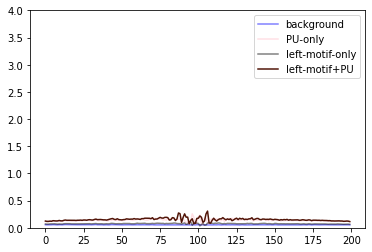

In [15]:

plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(puu_footprint[0][400:600], label="PU-only", c = "pink", alpha=0.5)
plt.plot(left_footprint[0][400:600], label="left-motif-only", c = "black", alpha=0.5)
plt.plot(left_puu_footprint[0][400:600], label="left-motif+PU", c = "#501407")

plt.ylim((0,4))
plt.legend()
plt.show()

Hetero-dimer

8/8 [==============================] - 8s 1s/step


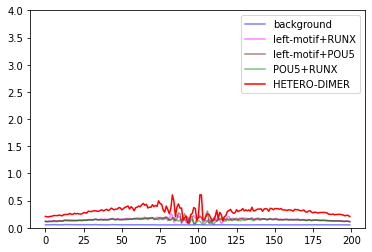

In [16]:
motif =  "TAGTCATCCGGGAAATGCAAATCAAAACCACAACG"
batch_size=128
full_footprint = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)

plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(left_runx_footprint[0][400:600], label="left-motif+RUNX", c = "magenta", alpha=0.5)
plt.plot(left_puu_footprint[0][400:600], label="left-motif+POU5", c = "#501407", alpha=0.5)
plt.plot(puu_runx_footprint[0][400:600], label="POU5+RUNX", c = "green", alpha=0.5)
plt.plot(full_footprint[0][400:600], label="HETERO-DIMER", c = "red")

plt.ylim((0,4))
plt.legend()
plt.show()

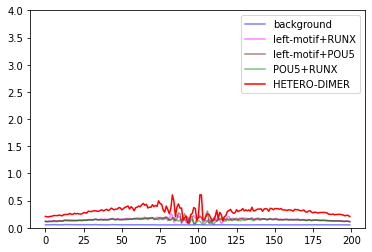

In [17]:
plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(left_runx_footprint[0][400:600], label="left-motif+RUNX", c = "magenta", alpha=0.5)
plt.plot(left_puu_footprint[0][400:600], label="left-motif+POU5", c = "#501407", alpha=0.5)
plt.plot(puu_runx_footprint[0][400:600], label="POU5+RUNX", c = "green", alpha=0.5)
plt.plot(full_footprint[0][400:600], label="HETERO-DIMER", c = "red")

plt.ylim((0,4))
plt.legend()
plt.show()

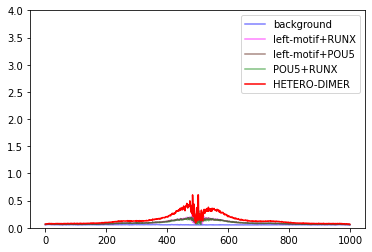

In [18]:
plt.plot(full_footprint_1[0], label="background", c = "b", alpha=0.5)
plt.plot(left_runx_footprint[0], label="left-motif+RUNX", c = "magenta", alpha=0.5)
plt.plot(left_puu_footprint[0], label="left-motif+POU5", c = "#501407", alpha=0.5)
plt.plot(puu_runx_footprint[0], label="POU5+RUNX", c = "green", alpha=0.5)
plt.plot(full_footprint[0], label="HETERO-DIMER", c = "red")

plt.ylim((0,4))
plt.legend()
plt.show()

In [19]:
print("baseline",full_footprint_1[1])
print("RUNX-only",runx_footprint[1]-full_footprint_1[1])
print("PU-only",puu_footprint[1]-full_footprint_1[1])
print("Left-motif only",left_footprint[1]-full_footprint_1[1])
print("RUNX+PU", puu_runx_footprint[1]-full_footprint_1[1])
print("Left-motif+RUNX",left_runx_footprint[1]-full_footprint_1[1])
print("Left-motif+PU",left_puu_footprint[1]-full_footprint_1[1])
print("hetero-dimer",full_footprint[1]-full_footprint_1[1])

baseline [56.001904]
RUNX-only [18.333065]
PU-only [37.546734]
Left-motif only [6.9054832]
RUNX+PU [33.159267]
Left-motif+RUNX [35.771854]
Left-motif+PU [36.86021]
hetero-dimer [90.37517]
